In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import scipy.io
import cv2

mat_file_path0 = '/content/drive/MyDrive/Colab Notebooks/studentdata0.mat'
mat_file_path1 = '/content/drive/MyDrive/Colab Notebooks/studentdata1.mat'
mat_file_path2 = '/content/drive/MyDrive/Colab Notebooks/studentdata2.mat'
mat_file_path3 = '/content/drive/MyDrive/Colab Notebooks/studentdata3.mat'
mat_file_path4 = '/content/drive/MyDrive/Colab Notebooks/studentdata4.mat'
mat_file_path5 = '/content/drive/MyDrive/Colab Notebooks/studentdata5.mat'
mat_file_path6 = '/content/drive/MyDrive/Colab Notebooks/studentdata6.mat'
mat_file_path7 = '/content/drive/MyDrive/Colab Notebooks/studentdata7.mat'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [253]:
from __future__ import annotations

from math import pi
from typing import Dict, List, NamedTuple, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
from cv2 import Rodrigues, solvePnP
from scipy.io import loadmat

savedCovMatrix = np.array(
    [
        [ 0.01124641, -0.00167305, -0.00189018,  0.00532129, -0.00396055, -0.00028349],
        [-0.00167305,  0.00544109,  0.0002523,  -0.00102443,  0.00326998, -0.00467435],
        [-0.00189018,  0.0002523,   0.00119224, -0.00165101,  0.00271911,  0.00011026],
        [ 0.00532129, -0.00102443, -0.00165101,  0.00633645, -0.00593225, -0.00243686],
        [-0.00396055,  0.00326998,  0.00271911, -0.00593225,  0.0146031,  -0.00101018],
        [-0.00028349, -0.00467435,  0.00011026, -0.00243686, -0.00101018,  0.00723985]])

class ImagePoint(NamedTuple):
    # holds pixel coordinates in a 2D space
    pixel_x: int
    pixel_y: int

    def to_coordinates() -> Point3D:
        # placeholder method to convert 2D pixel coordinates to 3D coordinates
        pass

class Point3D(NamedTuple):
    # represents a point in 3D space
    coord_x: float
    coord_y: float
    coord_z: float = 0.0

class TagLayout(NamedTuple):

    tag_id: str
    bottomLeftCorner: Union[Point3D, ImagePoint]
    bottomRightCorner: Union[Point3D, ImagePoint]
    topRightCorner: Union[Point3D, ImagePoint]
    topLeftCorner: Union[Point3D, ImagePoint]

class MeasurementData(NamedTuple):
    imageData: np.ndarray
    tagList: List[TagLayout]
    dataTime: float
    rotationRpy: np.ndarray
    drpy: np.ndarray
    accelVector: np.ndarray
    angularVelocity: np.ndarray

class TruePose(NamedTuple):
    dataTime: float
    position_x: float
    position_y: float
    position_z: float
    rotationRoll: float
    rotationPitch: float
    rotationYaw: float
    velocity_x: float
    velocity_y: float
    velocity_z: float
    angularVelocity_x: float
    angularVelocity_y: float
    angularVelocity_z: float

class LayoutMap:

    def __init__(self, tagPositions: Optional[Dict[int, Point3D]] = None, camMat: Optional[np.ndarray] = None, disCoeff: Optional[np.ndarray] = None,):
        if tagPositions is None:
            self.givenLayout()
        else:
            self.tagPositions = tagPositions

        if camMat is None:
            self.camMat = np.array([[314.1779, 0, 199.4848], [0, 314.2218, 113.7838], [0, 0, 1]])
        else:
            self.camMat = camMat

        if disCoeff is None:
            self.disCoeff = np.array([-0.438607, 0.248625, 0.00072, -0.000476, -0.0911])
        else:
            self.disCoeff = disCoeff

    def givenLayout(self):
        # Define tag positions in a grid formation
        self.tagPositions = {}
        tagGrid = [
            [0, 12, 24, 36, 48, 60, 72, 84, 96],
            [1, 13, 25, 37, 49, 61, 73, 85, 97],
            [2, 14, 26, 38, 50, 62, 74, 86, 98],
            [3, 15, 27, 39, 51, 63, 75, 87, 99],
            [4, 16, 28, 40, 52, 64, 76, 88, 100],
            [5, 17, 29, 41, 53, 65, 77, 89, 101],
            [6, 18, 30, 42, 54, 66, 78, 90, 102],
            [7, 19, 31, 43, 55, 67, 79, 91, 103],
            [8, 20, 32, 44, 56, 68, 80, 92, 104],
            [9, 21, 33, 45, 57, 69, 81, 93, 105],
            [10, 22, 34, 46, 58, 70, 82, 94, 106],
            [11, 23, 35, 47, 59, 71, 83, 95, 107],
        ]

        # Define constants for grid spacing and extra offset for every three columns
        initialOffset = 0.152
        columnOffsetIncrement = 0.178 - 0.152

        # Iterate over each row and column of the tag grid
        for rowNum, currentRow in enumerate(tagGrid):
            xCoord = initialOffset * (rowNum * 2)  # Calculate base x position
            for colNum, tag in enumerate(currentRow):
                yCoord = initialOffset * (colNum * 2)  # Calculate base y position
                if colNum >= initialOffset:
                    yCoord += columnOffsetIncrement  # Add extra offset after third column
                if colNum >= 6:
                    yCoord += columnOffsetIncrement  # Add another offset after sixth column

                # Define corners of the tag based on its calculated x and y positions
                topLeftCorner = Point3D(xCoord, yCoord, 0)
                topRightCorner = Point3D(xCoord, yCoord + initialOffset, 0)
                bottomRightCorner = Point3D(xCoord + initialOffset, yCoord + initialOffset, 0)
                bottomLeftCorner = Point3D(xCoord + initialOffset, yCoord, 0)

                # Store the layout for each tag in the tagPositions dictionary
                self.tagPositions[tag] = TagLayout(
                    tag_id=tag, topLeftCorner=topLeftCorner, topRightCorner=topRightCorner,
                    bottomRightCorner=bottomRightCorner, bottomLeftCorner=bottomLeftCorner,)

    def getPose(self, tagPositions: List[TagLayout]) -> Tuple[np.ndarray, np.ndarray]:
        # Flatten the lists of world and image points using list comprehensions
        worldPts = np.array([
            getattr(self.tagPositions[tag.tag_id], corner)
            for tag in tagPositions
            for corner in ['bottomLeftCorner', 'bottomRightCorner', 'topRightCorner', 'topLeftCorner']
        ], dtype=np.float32).reshape(-1, 3)

        imgPts = np.array([
            getattr(tag, corner)
            for tag in tagPositions
            for corner in ['bottomLeftCorner', 'bottomRightCorner', 'topRightCorner', 'topLeftCorner']
        ], dtype=np.float32).reshape(-1, 2)

        # Solve the PnP problem to obtain the rotation vector and translation vector
        _, rotVector, worldTranslationVector = solvePnP(worldPts, imgPts, self.camMat, self.disCoeff, flags=cv2.SOLVEPNP_ITERATIVE)

        # Convert rotation vector to rotation matrix
        rotMat, _ = Rodrigues(rotVector)

        # Define the rotation and translation for camera to drone coordinate frame transformation
        rotZ = np.array([[np.cos(np.pi / 4), -np.sin(np.pi / 4), 0], [np.sin(np.pi / 4), np.cos(np.pi / 4), 0], [0, 0, 1]])
        rotX = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])
        getRot = np.dot(rotX, rotZ)
        camOffset = np.array([-0.04, 0, -0.03])

        # Create homogeneous transformation matrices
        cameraToDroneTransform = np.eye(4)
        cameraToDroneTransform[:3, :3] = getRot
        cameraToDroneTransform[:3, 3] = camOffset

        cameraToWorldTransform = np.eye(4)
        cameraToWorldTransform[:3, :3] = rotMat
        cameraToWorldTransform[:3, 3] = worldTranslationVector.flatten()

        # Compute the transformation from drone to world frame
        droneToWorldTransform = np.linalg.inv(cameraToWorldTransform) @ cameraToDroneTransform

        # Extract the orientation in Euler angles and position
        worldPosition = droneToWorldTransform[:3, 3]
        eulerOrientation = rotMatToEuler(droneToWorldTransform[:3, :3])

        return eulerOrientation, worldPosition


def rotMatToEuler(rotMatrix: np.ndarray,) -> Tuple[float, float, float]:
    # extract rotation elements
    m11, m12, m13 = rotMatrix[0]
    m21, m22, m23 = rotMatrix[1]
    m31, m32, m33 = rotMatrix[2]

    # Check for gimbal lock cases where pitch is near +/- 90 degrees
    if np.isclose(m31, 1, atol=1e-8):
        rotYaw = 0
        rotPitch = -np.pi / 2
        rotRoll = np.arctan2(-m23, m22)
    elif np.isclose(m31, -1, atol=1e-8):
        rotYaw = 0
        rotPitch = np.pi / 2
        rotRoll = np.arctan2(m23, m22)
    else:
        # Compute yaw, pitch, roll
        rotPitch = -np.arcsin(m31)  # Pitch is negative as per equation, m31 = sin(pitch)
        rotYaw = np.arctan2(m32 / np.cos(rotPitch), m33 / np.cos(rotPitch))  # m32 = sin(yaw)cos(pitch), m33 = cos(yaw)cos(pitch)
        rotRoll = np.arctan2(m21 / np.cos(rotPitch), m11 / np.cos(rotPitch))  # m21 = sin(roll)cos(pitch), m11 = cos(roll)cos(pitch)

    return rotYaw, rotPitch, rotRoll

def getYawPitchRoll(rotationVector: np.ndarray,) -> Tuple[float, float, float]:
    # convert 3x1 Rodrigues rotation vector to a rotation matrix
    rotMatrix, _ = cv2.Rodrigues(rotationVector)

    # extract yaw, pitch, and roll from rotation matrix
    calculatedYaw = np.arctan2(rotMatrix[1, 0], rotMatrix[0, 0])
    calculatedPitch = np.arctan2(-rotMatrix[2, 0], np.sqrt(rotMatrix[2, 1] ** 2 + rotMatrix[2, 2] ** 2))
    calculatedRoll = np.arctan2(rotMatrix[2, 1], rotMatrix[2, 2])

    return calculatedYaw, calculatedPitch, calculatedRoll

def parseData(filepath: str) -> Tuple[List[MeasurementData], List[TruePose]]:
    loadedData = loadmat(filepath, simplify_cells=True)
    rawData = loadedData["data"]  # Raw measurement data from sensors and cameras
    timeStampsData = loadedData["time"]  # Timestamps for each data point
    viconData = loadedData["vicon"]  # Ground truth data from Vicon system

    data: List[MeasurementData] = []  # List to hold parsed measurement data objects

    # Iterate over each entry in the raw data loaded from the file
    for tagIndex, datum in enumerate(rawData):
        tagList: List[TagLayout] = []  # List to hold tag layout data for each measurement

        # Ensure consistency in data format for single tag cases
        if isinstance(datum["id"], int):
            datum["id"] = [datum["id"]]
            for tagCorner in ["p1", "p2", "p3", "p4"]:
                datum[tagCorner] = [[datum[tagCorner][0]], [datum[tagCorner][1]]]

        # Build list of tags with their corners' positions
        for tagIndex, id in enumerate(datum["id"]):
            tagList.append(
                TagLayout(
                    tag_id=id,
                    bottomLeftCorner=ImagePoint(datum["p1"][0][tagIndex], datum["p1"][1][tagIndex]),
                    bottomRightCorner=ImagePoint(datum["p2"][0][tagIndex], datum["p2"][1][tagIndex]),
                    topRightCorner=ImagePoint(datum["p3"][0][tagIndex], datum["p3"][1][tagIndex]),
                    topLeftCorner=ImagePoint(datum["p4"][0][tagIndex], datum["p4"][1][tagIndex]),
                ))

        # Handling missing data for angular velocity and other parameters
        drpy = datum.get("drpy", np.zeros_like(datum["rpy"]))  # Default to zeros if 'drpy' is missing
        omg = datum.get("drpy", datum.get("omg"))  # Use 'drpy' if present, otherwise 'omg'

        # Create a measurement data object for each entry in the raw data
        data.append(MeasurementData(
            imageData=datum["img"],
            tagList=tagList,
            dataTime=datum["t"],
            rotationRpy=datum["rpy"],
            drpy=drpy,
            accelVector=datum["acc"],
            angularVelocity=omg
        ))

    # Create ground truth data objects
    groundTruth = [
        TruePose(
            dataTime=dataTime,
            position_x=position_x, position_y=position_y, position_z=position_z,
            rotationRoll=rotationRoll, rotationPitch=rotationPitch, rotationYaw=rotationYaw,
            velocity_x=velocity_x, velocity_y=velocity_y, velocity_z=velocity_z,
            angularVelocity_x=angularVelocity_x, angularVelocity_y=angularVelocity_y, angularVelocity_z=angularVelocity_z
        ) for dataTime, (position_x, position_y, position_z, rotationRoll, rotationPitch, rotationYaw, velocity_x, velocity_y, velocity_z, angularVelocity_x, angularVelocity_y, angularVelocity_z)
        in zip(timeStampsData, zip(*[viconData[i] for i in range(12)]))
    ]

    return data, groundTruth

def getEstimatedPose(groundTruthPoses: List[TruePose], measuredData: MeasurementData) -> np.ndarray:
    dataTime = measuredData.dataTime

    # Use np.searchsorted to find the right place to interpolate
    truePoseTimestamps = np.array([gt.dataTime for gt in groundTruthPoses])
    insertIndex = np.searchsorted(truePoseTimestamps, dataTime)

    if insertIndex == 0 or insertIndex == len(truePoseTimestamps):
        raise ValueError("Timestamp out of bounds of ground truth data.")

    # Extract the nearest points before and after the estimated time
    previousPose = groundTruthPoses[insertIndex - 1]
    nextPose = groundTruthPoses[insertIndex]

    # Calculate the time differences
    timeToPrevious = dataTime - previousPose.dataTime
    timeToNext = nextPose.dataTime - dataTime
    total_delta = nextPose.dataTime - previousPose.dataTime

    # Calculate the interpolation weights
    previousWeight = timeToNext / total_delta
    nextWeight = timeToPrevious / total_delta

    # Attributes list for dynamic extraction
    attrs = ['position_x', 'position_y', 'position_z', 'rotationRoll', 'rotationPitch', 'rotationYaw']

    # Construct the vectors from the ground truth data using attributes list
    previousPoseVector = np.array([getattr(previousPose, attr) for attr in attrs]).reshape(6, 1)
    nextPoseVector = np.array([getattr(nextPose, attr) for attr in attrs]).reshape(6, 1)

    # Perform the interpolation
    smoothedPose = previousWeight * previousPoseVector + nextWeight * nextPoseVector

    return smoothedPose


In [255]:
from typing import List, Tuple
import numpy as np

class ParticleFilter:

    def __init__(self, getParticleCount=1_000, covarianceMatrix: np.ndarray = savedCovMatrix, minimumParticleRatio=0.5, noiseScalePosition: float = 105, noiseScaleGyro: float = 0.01,):
        # Initializes the Particle Filter with a specific number of particles
        self.getParticleCount = getParticleCount
        # Covariance matrix to model the measurement noise
        self.covarianceMatrix = covarianceMatrix
        # Minimum ratio of effective particles to total particles to trigger resampling
        self.minimumParticleRatio = (minimumParticleRatio * getParticleCount)
        # LayoutMap instance to manage spatial configurations and transformations
        self.map = LayoutMap()
        # Noise scale for position to simulate process noise
        self.noiseScalePosition = noiseScalePosition
        # Noise scale for gyroscope to simulate measurement noise in angular velocity
        self.noiseScaleGyro = noiseScaleGyro

    def update(self, measuredSt: np.ndarray) -> np.ndarray:
        # Prepare a measurement matrix to apply the covariance matrix to the measured state
        measurementMatrix = np.zeros((6, 15))  # Setup a 6x15 zero matrix
        measurementMatrix[:6, :6] = np.identity(6)  # Place a 6x6 identity matrix at the top-left to preserve the first six state dimensions

        # Extracts the diagonal elements of the covariance matrix and reshapes for the matrix operation
        covarianceDiagonal = np.diag(self.covarianceMatrix).reshape((6, 1))

        # Apply the measurement matrix to the measured state and add noise covariance
        return np.dot(measurementMatrix, measuredSt) + covarianceDiagonal

    def resample(self, particles: np.ndarray, samplingWeights: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        # Normalize the weights
        normalizedWeights = samplingWeights / samplingWeights.sum()

        # Generate the cumulative sum of the weights
        totalWeights = np.cumsum(normalizedWeights)

        # Generate uniformly spaced sample points
        getSeedRandom = np.random.uniform(0, 1 / self.getParticleCount)
        getSamplingPoints = getSeedRandom + np.arange(self.getParticleCount) / self.getParticleCount

        # Find indices where sample points fit in the cumulative sum array
        indexArray = np.searchsorted(totalWeights, getSamplingPoints)

        # Resample particles and weights according to these indices
        newParticles = particles[indexArray]
        newWeights = np.ones_like(samplingWeights) / self.getParticleCount  # Reset weights to uniform

        return newParticles, newWeights

    def measurement(self, data: MeasurementData) -> np.ndarray:
        # Raise an error if no AprilTags are detected in the data
        if not data.tagList:
            raise ValueError("No AprilTags present on data point")

        # Extract the pose (orientation and position) from the detected tags
        orientation, position = self.map.getPose(data.tagList)

        # Initialize a state vector with zeros for all the expected measurements and states
        measurementState = np.zeros((15, 1))
        # Set the position and orientation in the state vector
        measurementState[0:3] = position.reshape((3, 1))
        measurementState[3:6] = np.array(orientation).reshape((3, 1))

        return measurementState

    def predict(self, particles: np.ndarray, deltaT: float, accelerometer: np.ndarray, gyroscope: np.ndarray) -> np.ndarray:
        # Add noise to the accelerometer and gyroscope readings to simulate real-world measurement inaccuracies
        accelNoise = np.random.normal(scale=self.noiseScalePosition, size=(self.getParticleCount, 3, 1))
        gyroNoise = np.random.normal(scale=self.noiseScaleGyro, size=(self.getParticleCount, 3, 1))

        # Combine actual measurements with the generated noise
        accelWithNoise = accelerometer.reshape(3, 1) + accelNoise
        gyroWithNoise = gyroscope.reshape(3, 1) + gyroNoise

        # Extract orientation angles from the particles
        particleOrientations = particles[:, 3:6]
        thetaAngles, phiAngles, psiAngles = particleOrientations[:, 0], particleOrientations[:, 1], particleOrientations[:, 2]

        # Calculate trigonometric functions needed for the orientation transformation
        cosTheta, sinTheta = np.cos(thetaAngles), np.sin(thetaAngles)
        cosPhi, sinPhi = np.cos(phiAngles), np.sin(phiAngles)
        cosPsi, sinPsi = np.cos(psiAngles), np.sin(psiAngles)

        # Compute the inverse transformation matrix from gyroscopic angles
        inverseGMatrix = np.array([
            cosTheta, sinTheta * sinPhi / cosPhi, np.zeros_like(thetaAngles),
            np.zeros_like(thetaAngles), np.ones_like(thetaAngles), -cosTheta * sinPhi / cosPhi,
            -sinTheta / cosPhi, np.zeros_like(thetaAngles), cosTheta / cosPhi
        ]).T.reshape(self.getParticleCount, 3, 3)

        # Calculate the rotation matrix for the current particle orientation
        rotationMatrix = np.array([
            cosPsi * cosTheta - sinPhi**2 * sinTheta, -cosPhi * sinPsi, cosPsi * sinTheta + cosTheta * sinPhi * sinPsi,
            cosTheta * sinPsi + cosPsi * sinPhi * sinTheta, cosPhi * cosPsi, sinPsi * sinTheta - cosPsi * cosTheta * sinPhi,
            -cosPhi * sinTheta, sinPhi, cosPhi * cosTheta
        ]).T.reshape(self.getParticleCount, 3, 3)

        # Update particle velocities based on the current states and measurements
        particleVelocities = particles[:, 6:9]
        velocityUpdate = np.zeros_like(particles)
        velocityUpdate[:, 0:3] = particleVelocities
        velocityUpdate[:, 3:6] = np.matmul(inverseGMatrix, gyroWithNoise.reshape(self.getParticleCount, 3, 1))
        velocityUpdate[:, 6:9] = np.array([0, 0, -9.81]).reshape(3, 1) + np.matmul(rotationMatrix, accelWithNoise.reshape(self.getParticleCount, 3, 1))

        # Apply the time step to the velocity updates and add to the current particle states
        velocityUpdate *= deltaT
        particles += velocityUpdate

        return particles

    def updateWeights(self, particles: np.ndarray, prediction: np.ndarray) -> np.ndarray:
        # Calculate the difference between each particle's state and the predicted state
        deltaValues = particles[:, 0:6] - prediction[0:6]
        # Compute the weight for each particle using a Gaussian probability density function
        weightFactors = np.exp(-0.5 * np.sum(deltaValues ** 2, axis=1))
        # Normalize the weights so they sum to 1, making them proper probabilities
        normalizedWeights = weightFactors / np.sum(weightFactors)

        return normalizedWeights

    def weightedAverage(self, particles: np.ndarray, weights: np.ndarray) -> np.ndarray:
        # Apply weights to each particle's state, emphasizing particles with higher weights
        weightedParticles = particles * weights.reshape(self.getParticleCount, 1, 1)
        # Sum the weighted particles to get a single state estimate
        summedParticles = np.sum(weightedParticles, axis=0)
        # Normalize by total weight to compute the weighted average
        return summedParticles / np.sum(weights)

    def highestParticle(self, particles: np.ndarray, weights: np.ndarray) -> np.ndarray:
        # Identify the particle with the highest weight as the most likely state
        return particles[np.argmax(weights)]

    def avg(self, particles: np.ndarray) -> np.ndarray:
        # Calculate the simple average of all particle states, providing a baseline estimate
        return np.sum(particles, axis=0) / self.getParticleCount


    def initialParticles(self) -> np.ndarray:  # Using camelCase for the method name
        # Define ranges for each dimension: position (x, y, z) and orientation (yaw, pitch, roll)
        dimensionRanges = [
            (0.0, 3.0),  # x range
            (0.0, 3.0),  # y range
            (0.0, 1.5),  # z range
            (-0.5 * np.pi, 0.5 * np.pi),  # yaw range
            (-0.5 * np.pi, 0.5 * np.pi),  # pitch range
            (-0.5 * np.pi, 0.5 * np.pi)   # roll range
        ]

        # Extract lower and upper bounds
        lowerBounds, upperBounds = zip(*dimensionRanges)  # This unpacks the range tuples into two tuples: lower and upper bounds

        # Generate initial random values for position and orientation
        initialStates = np.random.uniform(low=lowerBounds, high=upperBounds, size=(self.getParticleCount, 6))

        # Add nine columns of zeros for the velocities and other dynamic states, then add a dimension for uniformity
        initialStates = np.hstack([initialStates, np.zeros((self.getParticleCount, 9))])
        initialStates = initialStates[:, :, np.newaxis]  # Add a new axis to match expected shape

        return initialStates

    def run(self, estimatedPositions: List[MeasurementData], estimateMethod: str = "weighted") -> Tuple[np.ndarray, np.ndarray]:
        # Define valid estimation methods
        validMethods = ["weighted", "average", "highest"]
        # Validate the estimation method provided
        if estimateMethod not in validMethods:
            raise ValueError("Invalid estimate method")

        # Check if all estimated positions have associated AprilTag data; raise error if any are missing
        if not all(pos.tagList for pos in estimatedPositions):
            missingTags = [i for i, pos in enumerate(estimatedPositions) if not pos.tagList]
            raise ValueError(f"No AprilTags present on data points at indices {missingTags}")

        # Initialize arrays for storing estimates and particle histories
        numPositions = len(estimatedPositions)
        estimates = np.zeros((numPositions - 1, 15, 1))
        particleHistory = np.zeros((numPositions, self.getParticleCount, 15, 1))

        # Initialize particles and record the initial state in particle history
        particles = self.initialParticles()
        particleHistory[0] = particles
        time = estimatedPositions[0].dataTime
        weights = np.ones((self.getParticleCount, 1)) / self.getParticleCount

        # Process each position in the list of estimated positions
        for index in range(1, numPositions):
            # Optional: Output progress for every 10 data points processed
            if index % 10 == 0:
                print(f"\r{index}/{numPositions}", end="")

            # Get current position and calculate time difference from the previous position
            currentPosition = estimatedPositions[index]
            deltaTime = currentPosition.dataTime - time
            time = currentPosition.dataTime

            # Predict the next state of particles based on the current state and measured inputs
            particles = self.predict(particles, deltaTime, currentPosition.accelVector, currentPosition.angularVelocity)
            particleHistory[index] = particles

            # Measure the current state and update particle states based on the measurement
            currentMeasurement = self.measurement(currentPosition)
            currentPrediction = self.update(currentMeasurement)
            # Append zeros for velocity states as they are not updated in this step
            currentPrediction = np.concatenate((currentPrediction, np.zeros((9, 1))))

            # Update particle weights based on the prediction error
            weights = self.updateWeights(particles, currentPrediction)

            # Determine estimates based on the specified method
            if estimateMethod == "weighted":
                estimate = self.weightedAverage(particles, weights)
            elif estimateMethod == "average":
                estimate = self.avg(particles)
            elif estimateMethod == "highest":
                estimate = self.highestParticle(particles, weights)

            # Resample particles based on the updated weights to focus on more probable states
            particles, weights = self.resample(particles, weights)
            estimates[index - 1] = estimate

        return estimates, particleHistory


In [257]:
from math import pi
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def rmseMethodsPlot(groundTruths: List[np.ndarray], weightedEstimates: List[np.ndarray], averageEstimates: List[np.ndarray],highestWeightEstimates: List[np.ndarray],) -> plt.Figure:

    if len(groundTruths) != len(weightedEstimates) or len(groundTruths) != len(averageEstimates) or len(groundTruths) != len(highestWeightEstimates):
        raise ValueError("All input lists must have the same length.")

    if len(groundTruths) == len(weightedEstimates) + 1:
        groundTruths = groundTruths[1:]

    weightedRmse = [rmse(np.array([gt[0], gt[1], gt[2]]).reshape(3, 1), est[:3]) for gt, est in zip(groundTruths, weightedEstimates)]
    averageRmse = [rmse(np.array([gt[0], gt[1], gt[2]]).reshape(3, 1), est[:3]) for gt, est in zip(groundTruths, averageEstimates)]
    highestRmse = [rmse(np.array([gt[0], gt[1], gt[2]]).reshape(3, 1), est[:3]) for gt, est in zip(groundTruths, highestWeightEstimates)]

    print(f"RMSE - Weighted Average: {np.mean(weightedRmse):.3f}")
    print(f"RMSE - Average: {np.mean(averageRmse):.3f}")
    print(f"RMSE - Highest Weight: {np.mean(highestRmse):.3f}")

    with plt.style.context('default'):
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.set_title("Comparison of RMSE Values")
        ax.set_xlabel("T")
        ax.set_ylabel("RMSE")

        ax.plot(weightedRmse, color='blue', label="Avg Weighted")
        ax.plot(averageRmse, color='green', label="Avg")
        ax.plot(highestRmse, color='red', label="Highest-Weight")

        ax.legend()
        ax.grid(True)

        return fig

def get3DPlots(title: str, *plot_data) -> plt.Figure:
    if not plot_data:
        raise ValueError("No plotting arguments provided")
    if len(plot_data) % 2 != 0:
        raise ValueError("Arguments must be provided in pairs of label and data")

    with plt.style.context('classic'):
        figure = plt.figure(figsize=(10, 6))
        ax = figure.add_subplot(111, projection='3d')
        ax.set_title(title)
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.dist = 10

        for i in range(0, len(plot_data), 2):
            label, data_points = plot_data[i], plot_data[i+1]
            x_coords = [point[0] for point in data_points]
            y_coords = [point[1] for point in data_points]
            z_coords = [point[2] for point in data_points]

            colors = cm.viridis((np.array(z_coords) - min(z_coords)) / (max(z_coords) - min(z_coords)))
            ax.scatter3D(x_coords, y_coords, z_coords, c=colors, linewidths=0.5, label=label, depthshade=True)

        if len(plot_data) > 2:
            ax.legend()

        return figure

def getOriPlots(ground_truth: List[np.ndarray], estimates: List[np.ndarray], timestamps: List[float]) -> plt.Figure:
    estimated_orientations: List[np.ndarray] = [estimate[3:6] for estimate in estimates]

    yaw_gt = [gti[3] for gti in ground_truth]
    pitch_gt = [gti[4] for gti in ground_truth]
    roll_gt = [gti[5] for gti in ground_truth]

    roll_estimated = [orientation[2] for orientation in estimated_orientations]
    pitch_estimated = [orientation[1] for orientation in estimated_orientations]
    yaw_estimated = [orientation[0] for orientation in estimated_orientations]

    orientations_figure, axs = plt.subplots(3, 1, figsize=(10, 15))
    orientations_figure.suptitle("Orientation: GT vs Positions Estimated")

    estimate_timestamps = timestamps if len(timestamps) == len(estimates) else timestamps[1:]

    titles = ["Yaw", "Pitch", "Roll"]
    data = [(yaw_gt, yaw_estimated), (pitch_gt, pitch_estimated), (roll_gt, roll_estimated)]

    for i, (gt_data, est_data) in enumerate(data):
        axs[i].set_xlabel("T")
        axs[i].set_ylabel(titles[i])
        axs[i].set_title(titles[i])
        axs[i].grid(True)
        axs[i].plot(timestamps, gt_data, label="GT", color='blue')
        axs[i].plot(estimate_timestamps, est_data, label="Estimated", color='green')
        axs[i].legend()

    orientations_figure.tight_layout(rect=[0, 0.03, 1, 0.95])

    return orientations_figure

Loaded 864 measurement data points.
860/864

<ipython-input-257-0c51d9ca0405>:53: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 10


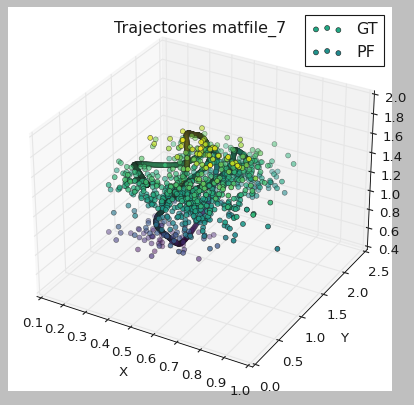

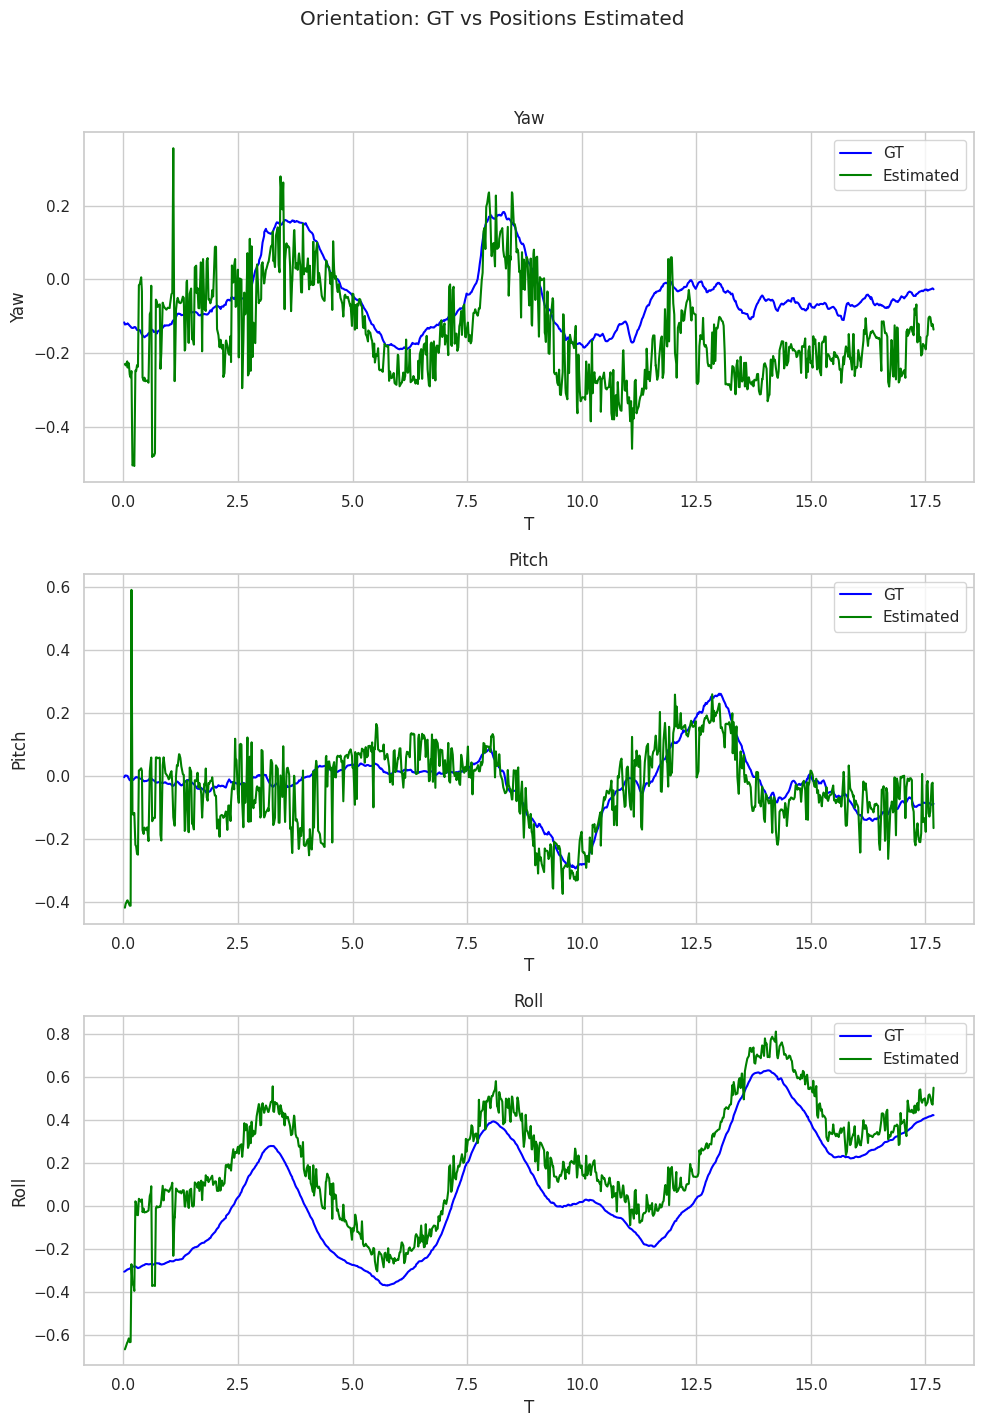

In [259]:
from time import time

if __name__ == "__main__":

    #mat_file_path0 = '/content/drive/MyDrive/Colab Notebooks/studentdata1.mat'
    datasetName = "matfile_7"

    readings, groundTruth = parseData(mat_file_path1)
    #readings, groundTruth = parseData(mat_file_path2)
    #readings, groundTruth = parseData(mat_file_path3)
    ##readings, groundTruth = parseData(mat_file_path4)
    #readings, groundTruth = parseData(mat_file_path5)
    #readings, groundTruth = parseData(mat_file_path6)
    #readings, groundTruth = parseData(mat_file_path7)

    # Print out the number of measurement data points loaded
    print(f"Loaded {len(readings)} measurement data points.")

    # Initialize lists to store processed data
    interpolatedGts = []  # Ground truths interpolated for comparison
    positionList = []  # Positions derived from tag readings
    orientationList = []  # Orientations derived from tag readings
    timeStamps = []  # Timestamps for each measurement
    measurementDataList = []  # List to hold valid measurements with tags

    # Process each measurement
    for singleMeasurement in readings:
        if not singleMeasurement.tagList:
            continue  # Skip measurements without any tags
        try:
            # Attempt to interpolate ground truth data for the current measurement
            interpolatedGts.append(getEstimatedPose(groundTruth, singleMeasurement))
        except:
            continue  # If an error occurs, skip to the next measurement
        # Store valid measurements and calculate poses
        measurementDataList.append(singleMeasurement)
        orientation, position = LayoutMap().getPose(singleMeasurement.tagList)
        positionList.append(position)
        orientationList.append(orientation)
        timeStamps.append(singleMeasurement.dataTime)

    # Initialize the particle filter with specific parameters
    particleFilter = ParticleFilter(
        getParticleCount=1500, noiseScalePosition=105.0, noiseScaleGyro=0.30
    )
    startTime = time()  # Record the start time for performance measurement

    # Run the particle filter and store the estimates
    estimatesTenK, _ = particleFilter.run(measurementDataList, estimateMethod="highest")

    # Compute RMSE between interpolated ground truths and filter estimates for positions
    rmseError = rmse(
        np.array([[gti[0], gti[1], gti[2]] for gti in interpolatedGts[1:]]),
        np.array([[estimate[0], estimate[1], estimate[2]] for estimate in estimatesTenK]),)

    # Compute RMSE for orientation comparison
    rmseError = rmse(
        np.array([[gti[3], gti[4], gti[5]] for gti in interpolatedGts[1:]]),
        np.array([[estimate[3], estimate[4], estimate[5]] for estimate in estimatesTenK]),)

    # Generate a 3D plot to visualize trajectories from ground truth and particle filter
    isometricFigure = get3DPlots(
        f"Trajectories {datasetName}", "GT",
        [[gti.position_x, gti.position_y, gti.position_z] for gti in groundTruth],
        "PF", [[estimate[0], estimate[1], estimate[2]] for estimate in estimatesTenK],)

    # Create overlay plots for orientation comparison
    orientationsOverlay = getOriPlots(interpolatedGts, estimatesTenK, timeStamps,)

    # Display the overlay plots
    plt.show(orientationsOverlay)


860/864Time to run weighted for matfile_1: 6.37 seconds
860/864Time to run average for matfile_1: 4.12 seconds
860/864Time to run highest for matfile_1: 4.17 seconds
RMSE - Weighted Average: 0.106
RMSE - Average: 0.108
RMSE - Highest Weight: 0.109


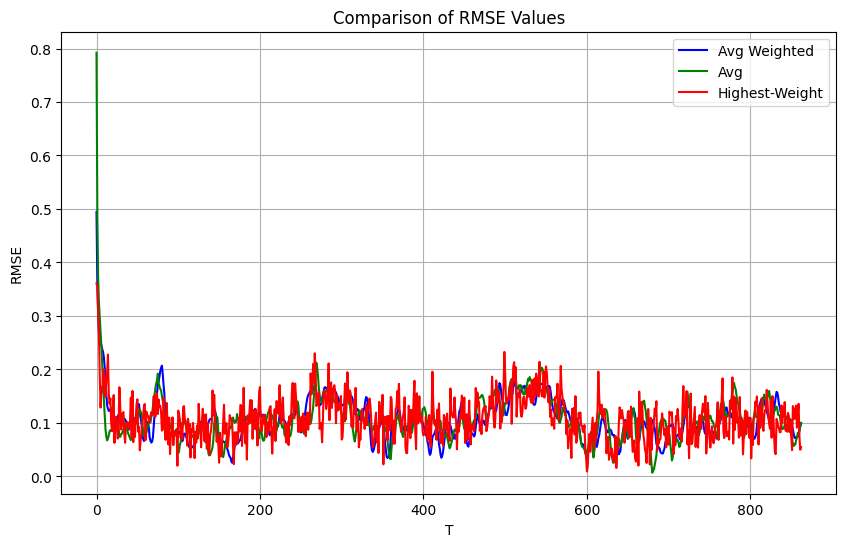

860/864Time to run with 250 particles: 2.36 seconds
Mean RMSE with 250 particles: 0.15
860/864Time to run with 500 particles: 2.60 seconds
Mean RMSE with 500 particles: 0.13
860/864Time to run with 750 particles: 3.44 seconds
Mean RMSE with 750 particles: 0.12
860/864Time to run with 1000 particles: 4.97 seconds
Mean RMSE with 1000 particles: 0.12
860/864Time to run with 2000 particles: 4.02 seconds
Mean RMSE with 2000 particles: 0.11
860/864Time to run with 3000 particles: 5.70 seconds
Mean RMSE with 3000 particles: 0.11
860/864Time to run with 4000 particles: 8.07 seconds
Mean RMSE with 4000 particles: 0.10
860/864Time to run with 5000 particles: 7.76 seconds
Mean RMSE with 5000 particles: 0.11


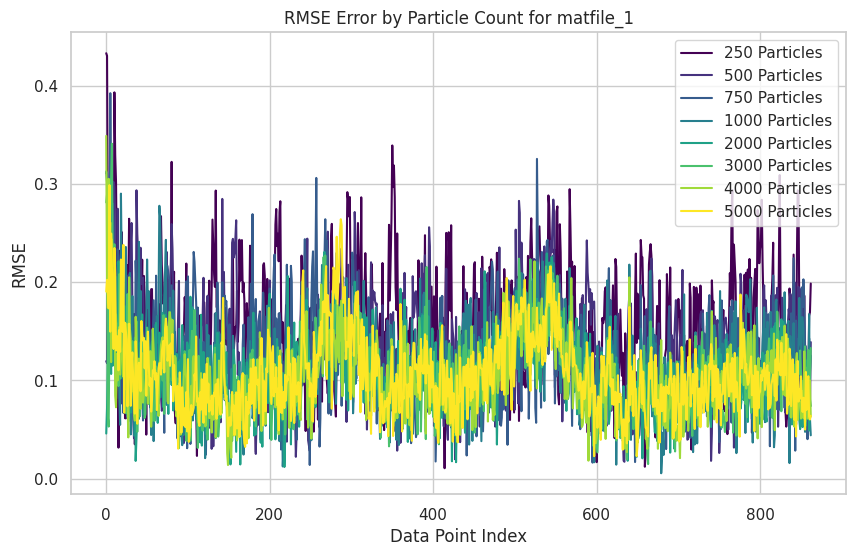

In [243]:
from time import time
from typing import Dict, List
import numpy as np
from matplotlib import pyplot as plt

def methodTests(dataset: str):
    datasetName = "matfile_1"
    readings, gt = parseData(dataset)

   # Lists to store interpolated ground truths and measurement data
    interpolatedGts = []
    measurementData = []
    # Process each datum in the dataset
    for datum in readings:
        if not datum.tagList:
            continue
        try:
            # interpolate the ground truth positions for the measurement
            interpolatedGts.append(getEstimatedPose(gt, datum))
            measurementData.append(datum)
        except:
            continue
    #Initialize three particle filters with different estimation methods
    particleFilterWeighted = ParticleFilter(getParticleCount=1500)
    particleFilterAverage = ParticleFilter(getParticleCount=1500)
    particleFilterHighest = ParticleFilter(getParticleCount=1500)

    # Record and calculate the duration of the weighted particle filter run
    startTimeWeighted = time()
    estimatesWeighted, _ = particleFilterWeighted.run(measurementData, estimateMethod="weighted")
    durationWeighted = time() - startTimeWeighted
    # Similarly, for the average and highest weight methods
    startTimeAverage = time()
    estimatesAverage, _ = particleFilterAverage.run(measurementData, estimateMethod="average")
    durationAverage = time() - startTimeAverage

    startTimeHighest = time()
    estimatesHighest, _ = particleFilterHighest.run(measurementData, estimateMethod="highest")
    durationHighest = time() - startTimeHighest
    # Adjust ground truths if their number exceeds estimates
    if len(interpolatedGts) > len(estimatesWeighted):
        interpolatedGts = interpolatedGts[1:]
    # Plot RMSE comparisons for all estimation methods
    rmseFigure = rmseMethodsPlot(interpolatedGts, estimatesWeighted, estimatesAverage, estimatesHighest)
    plt.show()

def particleCountTests(dataset: str):
    datasetName = "matfile_1"
    readings, gt = parseData(dataset)

    interpolatedGts = []
    measurementData = []
    for singleMeasurement in readings:
        if not singleMeasurement.tagList:
            continue
        try:
            interpolatedGts.append(getEstimatedPose(gt, singleMeasurement))
            measurementData.append(singleMeasurement)
        except Exception as e:
            print(f"Error processing data: {e}")
            continue

    plt.figure(figsize=(10, 6))

    # Define particle counts before using them
    particleCounts = [250, 500, 750, 1000, 2000, 3000, 4000, 5000]

    #define color map after particleCounts is defined
    colors = plt.cm.viridis(np.linspace(0, 1, len(particleCounts)))
    # Run particle filter for each particle count and plot RMSE
    for count, color in zip(particleCounts, colors):
        particleFilter = ParticleFilter(getParticleCount=count)
        startTime = time()
        particleEstimates, _ = particleFilter.run(measurementData, estimateMethod="highest")
        runDuration = time() - startTime
        print(f"Time to run with {count} particles: {runDuration:.2f} seconds")

        minDataLength = min(len(interpolatedGts), len(particleEstimates))
        rmseValues = [
            rmse(
                interpolatedGts[i][0:3].reshape((3, 1)),
                particleEstimates[i][0:3].reshape((3, 1))
            )
            for i in range(minDataLength)
        ]
        averageRmse = np.mean(rmseValues)
        print(f"Mean RMSE with {count} particles: {averageRmse:.2f}")

        plt.plot(rmseValues, label=f"{count} Particles", color=color)

    plt.title(f"RMSE Error by Particle Count for {datasetName}")
    plt.xlabel("Data Point Index")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)  # Enable the grid for better readability
    plt.show()


if __name__ == "__main__":
    #datasetPath = '/content/drive/MyDrive/Colab Notebooks/studentdata0.mat'
    datasetPath = '/content/drive/MyDrive/Colab Notebooks/studentdata1.mat'
    #datasetPath = '/content/drive/MyDrive/Colab Notebooks/studentdata2.mat'
    #datasetPath = '/content/drive/MyDrive/Colab Notebooks/studentdata3.mat'
    #datasetPath = '/content/drive/MyDrive/Colab Notebooks/studentdata4.mat'
    #datasetPath = '/content/drive/MyDrive/Colab Notebooks/studentdata5.mat'
    #datasetPath = '/content/drive/MyDrive/Colab Notebooks/studentdata6.mat'
    #datasetPath = '/content/drive/MyDrive/Colab Notebooks/studentdata7.mat'

    methodTests(datasetPath)
    particleCountTests(datasetPath)


In [123]:
from typing import List, Optional, Tuple
import numpy as np
from scipy.linalg import sqrtm

class unscentedKalmanFilter:

    def __init__(self, measCovMat: Optional[np.ndarray] = None, scalingFactor: float = 1, sigmaPointSpread: float = 1, distributionShape: float = 2.0,):
        # initialize filter parameters and state dimensions
        self.stateDimension = 15
        self.scalingFactor = scalingFactor
        self.sigmaPointSpread = sigmaPointSpread
        self.distributionShape = distributionShape
        # measurement covariance matrix, default or provided
        self.measCovMat = savedCovMatrix
        # calculate number of sigma points
        self.sigmaPts = 2 * self.stateDimension + 1
        # compute lambda for sigma point calculations
        self.lamb = self.sigmaPointSpread ** 2 * (self.stateDimension + self.scalingFactor) - self.stateDimension
        tempLambda = self.lamb + self.stateDimension
        # initialize weights for mean and covariance calculations
        self.meanWeights = np.full(self.sigmaPts, 1 / (2 * tempLambda))
        self.covWeights = np.full(self.sigmaPts, 1 / (2 * tempLambda))
        # adjust first weight differently based on lambda
        self.meanWeights[0] = self.lamb / tempLambda
        self.covWeights[0] = self.lamb / tempLambda + 1 - self.sigmaPointSpread ** 2 + self.distributionShape
        # instance of map for state vector calculations
        self.map = LayoutMap()

    def getSigmaPts(self, meanState: np.ndarray, covarianceMatrix: np.ndarray) -> np.ndarray:
        # create sigma points array
        sigmaPts = np.zeros((self.sigmaPts, self.stateDimension, 1))
        # first sigma point is the mean state
        sigmaPts[0] = meanState
        # calculate square root of scaled covariance matrix
        spreadMatrix = sqrtm((self.stateDimension + self.scalingFactor) * covarianceMatrix)
        # generate sigma points based on distribution around mean
        for i in range(self.stateDimension):
            sigmaPts[i + 1] = meanState + spreadMatrix[i].reshape((15, 1))
            sigmaPts[self.stateDimension+ i + 1] = meanState - spreadMatrix[i].reshape((15, 1))

        return sigmaPts

    def dynamicUpdate(self, state: np.ndarray, deltat: float, ua: np.ndarray, uw: np.ndarray) -> np.ndarray:
        # extract angles/linear velocity from state
        rollAngle, pitchAngle, yawAngle = state[3:6, 0]
        velocityVector = state[6:9, 0]
        gravity = -9.8

        # compute rotation matrices for transformation
        cosTheta, sinTheta = np.cos(rollAngle), np.sin(rollAngle)
        cosPhi, sinPhi = np.cos(pitchAngle), np.sin(pitchAngle)
        cosPsi, sinPsi = np.cos(yawAngle), np.sin(yawAngle)

        # inverse transformation from body to world frame
        inverseBodytoWorldTf = np.array([[cosTheta, 0, sinTheta], [sinPhi * sinTheta / cosPhi, 1.0, -cosTheta * sinPhi / cosPhi], [-sinTheta / cosPhi, 0, cosTheta / cosPhi]])

        # rotation matrix from body to world coordinates
        bodytoWorldRotation = np.array([
            [cosPsi * cosTheta - sinPhi * sinPsi * sinTheta, -cosPhi * sinPsi, cosPsi * sinTheta + cosTheta * sinPhi * sinPsi],
            [cosTheta * sinPsi + cosPsi * sinPhi * sinTheta, cosPhi * cosPsi, sinPsi * sinTheta - cosPsi * cosTheta * sinPhi],
            [-cosPhi * sinTheta, sinPhi, cosPhi * cosTheta]])

        # compute derivatives of position and orientations
        pdot = velocityVector
        omgTf = inverseBodytoWorldTf @ uw
        accTf = gravity + bodytoWorldRotation @ ua
        # calculate total derivatives and update state
        xdot = np.concatenate((pdot, omgTf, accTf, np.zeros(6)))[:, np.newaxis]
        newState = state + xdot * deltat

        return newState

    def correctState(self, state: np.ndarray, estimatedMean: np.ndarray, sigma: np.ndarray, sigmaPts) -> np.ndarray:
        # initialize predicted measurements array for each sigma point
        predictedMeasurements = np.zeros_like(sigmaPts)
        # fill predicted measurements by transforming each sigma point
        for i in range(self.sigmaPts):
            predictedMeasurements[i] = self.stateToMeeasurement(sigmaPts[i])
        # initialize mean of predicted measurements
        predictedStateMean = np.zeros((self.stateDimension, 1))
        # compute mean of predicted measurements using weighted average
        for i in range(0, self.sigmaPts):
            predictedStateMean += self.meanWeights[i] * predictedMeasurements[i]
        # initialize measurement noise covariance matrix
        measurementNoiseCov = np.zeros((self.stateDimension, self.stateDimension))
        measurementNoiseCov[0:6, 0:6] = np.diag(self.measCovMat)
        measurementCovariance = np.zeros((self.stateDimension, self.stateDimension))
        # calculate prediction errors
        predictionErrors = predictedMeasurements - predictedStateMean
        # compute measurement covariance matrix using prediction errors and weights
        for i in range(0, self.sigmaPts):
            measurementCovariance += self.covWeights[i] * np.dot(predictionErrors[i], predictionErrors[i].T)
        measurementCovariance += measurementNoiseCov

        # initialize cross covariance matrix
        crossCovariance = np.zeros((self.stateDimension, self.stateDimension))
        stateDifferences = sigmaPts - estimatedMean
        # compute cross covariance matrix
        for i in range(0, self.sigmaPts):
            crossCovariance += self.covWeights[i] * np.dot(stateDifferences[i], predictionErrors[i].T)

        # compute kalman gain using pseudo-inverse of measurement covariance matrix
        Kgain = np.dot(crossCovariance, np.linalg.pinv(measurementCovariance))
        # update state using kalman gain and difference between actual state and predicted state mean
        updatedState = estimatedMean + np.dot(Kgain, state - predictedStateMean)
        # update covariance using kalman gain and measurement covariance
        updatedCovariance = sigma - np.dot(Kgain, measurementCovariance).dot(Kgain.T)
        # adjust covariance matrix to ensure it is positive semi-definite
        updatedCovariance = self.adjustCovMat(updatedCovariance)

        return updatedState, updatedCovariance

    def adjustCovMat(self, updatedCovariance: np.ndarray, noise: float = 1e-3):
        # set number of iterations for covariance matrix adjustment
        maxIterations = 10
        # set initial regulation factor for numerical stability
        regulationFactor = noise

        # iteratively adjust covariance matrix
        for _ in range(maxIterations):
            # ensure covariance matrix is symmetric
            updatedCovariance = (updatedCovariance + updatedCovariance.T) / 2
            # compute eigenvalues and eigenvectors of covariance matrix
            eigenValues, eigenVectors = np.linalg.eig(updatedCovariance)
            # if all eigenvalues are positive, matrix is already valid

            if np.all(eigenValues > 0):
                return updatedCovariance
            # adjust eigenvalues to be positive and scale up regulation factor if needed
            eigenValues = np.where(eigenValues > 0, eigenValues, 0) + regulationFactor
            updatedCovariance = eigenVectors.dot(np.diag(eigenValues)).dot(eigenVectors.T)
            # increase regulation factor for next iteration if needed
            regulationFactor *= 10

        return updatedCovariance

    def stateToMeeasurement(self, state: np.ndarray) -> np.ndarray:
        measurementVector = np.zeros((self.stateDimension, 1))
        transformMatrix = np.zeros((6, self.stateDimension))
        transformMatrix[0:6, 0:6] = np.eye(6)

        noiseCovariance = np.diag(self.measCovMat).reshape(6, 1)
        measurementVector[0:6] = np.dot(transformMatrix, state) + noiseCovariance

        return measurementVector

    def statePropagation(self, sigmaPts: np.ndarray, ua: np.ndarray, uw: np.ndarray, deltat: float) -> Tuple[np.ndarray]:
       # initialize an array to hold predicted states for each sigma point
        predictedStates = np.zeros_like(sigmaPts)
        # update each sigma point based on dynamic model
        for i in range(sigmaPts.shape[0]):
            predictedStates[i, :] = self.dynamicUpdate(sigmaPts[i], deltat, uw, ua)
        # calculate mean of predicted states using weights
        predictedMean = np.zeros((self.stateDimension, 1))
        for i in range(0, self.sigmaPts):
            predictedMean += self.meanWeights[i] * predictedStates[i]

        # add some noise to process covariance as a part of uncertainty
        processNoiseCovariance = np.random.normal(scale=5e-1, size=(15, 15))
        stateDifferences = predictedStates - predictedMean
        # get covariance of predicted states
        covariancePrediction = np.zeros((self.stateDimension, self.stateDimension))
        for i in range(0, self.stateDimension):
            covariancePrediction += self.covWeights[i] * np.dot(stateDifferences[i], stateDifferences[i].T)
        covariancePrediction += processNoiseCovariance

        return predictedMean, covariancePrediction, predictedStates

    def stateVectorFromData(self, sensorData: MeasurementData, previousState: np.ndarray, previousTimestamp: float) -> np.ndarray:
        # initialize state vector with zeros
        stateVector = np.zeros((15, 1))
        # obtain pose from sensor data
        orientation, position = self.map.getPose(sensorData.tagList)
         # asign position and orientation to state vector
        stateVector[:3, 0] = position  # Position expected as a flat array
        stateVector[3:6, 0] = orientation  # Orientation expected as a flat array

        return stateVector


    def executeFilter(self, estimatePos: List[MeasurementData]) -> List[np.ndarray]:
        # create initial state vector from first sensor data
        stateVector = self.stateVectorFromData(estimatePos[0], np.zeros((self.stateDimension, 1)), 0.0)
        # initialize velocity part of state vector
        stateVector[6:9] = np.zeros((3, 1))
        # record initial timestamp
        prevTimeStamp = estimatePos[0].dataTime

         # initialize covariance matrix with small uncertainties
        calculateCovMat = np.eye(self.stateDimension) * 1e-3
        filteredPos = []

        # iterate over all sensor data to update state vector
        for data in estimatePos[1:]:

            # update state vector from data
            stateVector = self.stateVectorFromData(data, stateVector, prevTimeStamp)

            deltat = data.dataTime - prevTimeStamp
            prevTimeStamp = data.dataTime
            # generate sigma points for current state
            sigmaPts = self.getSigmaPts(stateVector, calculateCovMat)
            # propagate sigma points through process model
            predictedMean, predictedCovariance, predictedStates = self.statePropagation(sigmaPts, data.accelVector, data.angularVelocity, deltat)
            # correct predicted mean and covariance based on measurements
            updatedMean, updatedCovariance = self.correctState(stateVector, predictedMean, predictedCovariance, predictedStates)
            # update state vector and covariance matrix
            stateVector = updatedMean
            calculateCovMat = updatedCovariance
            # append updated state to list of filtered positions
            filteredPos.append(stateVector)

        return filteredPos

1470/1471

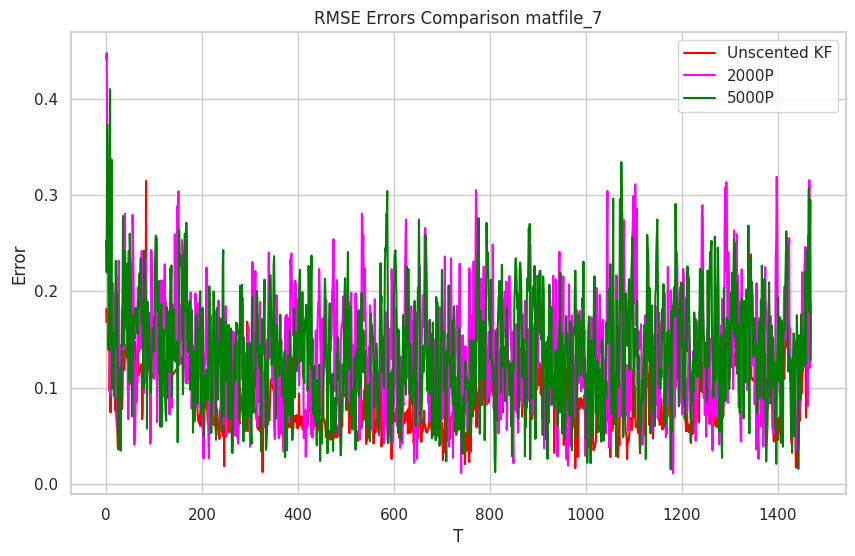

In [260]:
from time import time
from typing import Dict, List
import numpy as np
from matplotlib import pyplot as plt

def rmsePlot(title: str, *args) -> plt.Figure:
    # Checks if input arguments are provided and are in the correct format
    if not args:
        raise ValueError("No plotting arguments provided")
    if len(args) % 2 != 0:
        raise ValueError("Arguments must be provided in pairs of label and data")

    plotStyles = [
        ('red', '-'),  # Solid line for the first dataset
        ('magenta', '-'),  # Solid line for the second dataset
        ('green', '-')  # Solid line for the third dataset
    ]
    # Initialize plot
    figure, ax = plt.subplots(figsize=(10, 6))
    ax.set_title(title)
    ax.set_xlabel("T")
    ax.set_ylabel("Error")
    ax.grid(True)

    for (label, data), (color, linestyle) in zip(zip(args[::2], args[1::2]), plotStyles):
        ax.plot(data, label=label, color=color, linestyle=linestyle)
    # Add legend if more than one dataset is plotted
    if len(args) > 2:
        ax.legend()

    return figure

def wrapper(dataset: str):
    # Parse the dataset to get readings and ground truth
    datasetName = "matfile_7"
    readings, gt = parseData(dataset)

    # Lists to store data for further processing
    interpolatedGts = []
    measurementData = []

    # Process each reading to interpolate ground truth and store valid measurement data
    for datum in readings:
        if not datum.tagList:
            continue  # Skip readings without tagList
        try:
            interpolatedGts.append(getEstimatedPose(gt, datum))
            measurementData.append(datum)
        except:
            continue  # Continue to the next datum if an error occurs

    # Initialize and run Unscented Kalman Filter
    unscentedKF = unscentedKalmanFilter()
    startUKF = time()
    estimatesUKF = unscentedKF.executeFilter(measurementData)

    # Initialize and run Particle Filters with different particle counts
    particleFilter2K = ParticleFilter(getParticleCount=250)
    startTime2K = time()
    estimates2K, _ = particleFilter2K.run(measurementData, estimateMethod="highest")

    particleFilter5K = ParticleFilter(getParticleCount=250)
    startTime5K = time()
    estimates5K, _ = particleFilter5K.run(measurementData, estimateMethod="highest")

    # Determine the smallest dataset size to ensure comparison across the same number of estimates
    minLength = min(len(interpolatedGts), len(estimatesUKF), len(estimates2K), len(estimates5K))

    # Calculate RMSE for each method
    rmseUKF = [rmse(interpolatedGts[i][0:3].reshape((3, 1)), estimatesUKF[i][0:3].reshape((3, 1))) for i in range(minLength)]
    rmse2K = [rmse(interpolatedGts[i][0:3].reshape((3, 1)), estimates2K[i][0:3].reshape((3, 1))) for i in range(minLength)]
    rmse5K = [rmse(interpolatedGts[i][0:3].reshape((3, 1)), estimates5K[i][0:3].reshape((3, 1))) for i in range(minLength)]

    # Plot the RMSE comparison
    rmseFigure = rmseBasicPlot(f"RMSE Errors Comparison {datasetName}", "Unscented KF", rmseUKF, "2000P", rmse2K, "5000P", rmse5K)
    plt.show()


if __name__ == "__main__":
    #datasetPath = '/content/drive/MyDrive/Colab Notebooks/studentdata0.mat'
    #datasetPath = '/content/drive/MyDrive/Colab Notebooks/studentdata1.mat'
    #datasetPath = '/content/drive/MyDrive/Colab Notebooks/studentdata2.mat'
    #datasetPath = '/content/drive/MyDrive/Colab Notebooks/studentdata3.mat'
    #datasetPath = '/content/drive/MyDrive/Colab Notebooks/studentdata4.mat'
    #datasetPath = '/content/drive/MyDrive/Colab Notebooks/studentdata5.mat'
    #datasetPath = '/content/drive/MyDrive/Colab Notebooks/studentdata6.mat'
    datasetPath = '/content/drive/MyDrive/Colab Notebooks/studentdata7.mat'
    wrapper(datasetPath)